In [1]:
# Import necessary libraries
import geomdl
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve

from geomdl import BSpline
from geomdl import knotvector
from geomdl import NURBS

import math

cwd = os.getcwd()

# Load control points from CSV file
ctrlpts = []
with open(cwd + '/ctrl_points_file.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        if row != [] and row != ['x_pos', 'y_pos']:
            ctrlpts.append([float(row[0]), float(row[1])])

# Function to create a NURBS curve from control points
def create_nurbs_curve(control_points):
    # Initialize a NURBS curve object
    curve = NURBS.Curve()

    # Set the degrees of the curve
    curve.degree = 2

    # Set the control points
    curve.ctrlpts = control_points

    # Set the knot vector
    curve.knotvector = knotvector.generate(curve.degree, curve.ctrlpts_size)

    return curve

# Function to evaluate a curve at a given parameter t
def Z(t, curve):
    point = curve.evaluate_single(t)
    return point[:2]  # Discard the last coordinate (if 3D)

curve = create_nurbs_curve(ctrlpts)

In [2]:
# Function to calculate the derivative of a curve at a given parameter t
def Z_derivative(t, curve):
    dpoint = curve.derivatives(t, order=1)
    return np.array(dpoint[1][:2])

# Function to calculate the second derivative of a curve at a given parameter t
def Z_2nd_derivative(t, curve):
    dpoint = curve.derivatives(t, order=2)
    return np.array(dpoint[2][:2])

# Function to determine whether a point is within the NURBS curve
def point_inside_curve(point, curve_points):
    x, y = point
    n = len(curve_points)
    inside = False

    p1x, p1y = curve_points[0]
    for i in range(1, n + 1):
        p2x, p2y = curve_points[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside

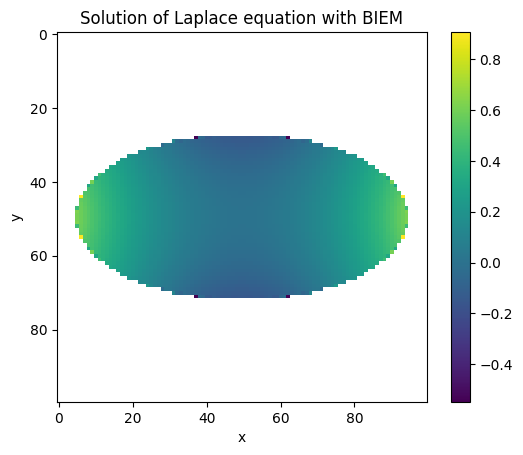

In [3]:
N = 200
a = 2
b = 1
nxgrid = 100
nygrid = 100
xmin = -2.2
xmax = 2.2
ymin = -2.2
ymax = 2.2

theta = np.linspace(0, 2 * np.pi, N + 1)
theta = theta[:-1]

x = a * np.cos(theta)
y = b * np.sin(theta)

tx = -a * np.sin(theta)
ty = b * np.cos(theta)

ax = -a * np.cos(theta)
ay = -b * np.sin(theta)
nx = np.zeros(N)
ny = np.zeros(N)
w = np.zeros(N)

for i in range(N):
    nx[i] = ax[i] / np.sqrt(ax[i] ** 2 + ay[i] ** 2)
    ny[i] = ay[i] / np.sqrt(ax[i] ** 2 + ay[i] ** 2)
    h = 1 / (N) * 2 * np.pi
    w[i] = h * np.sqrt(tx[i] ** 2 + ty[i] ** 2)

f = (x**2 - y**2) / (2*np.pi)

K = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if i == j:
            kappa = (tx[j] * ax[j] - ty[j] * ay[j]) / (tx[j] ** 2 + ty[j] ** 2) ** 1.5
            kappa = 1
            K[i, j] = -kappa / (4 * np.pi) * w[j]
        else:
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dot = nx[j] * dx + ny[j] * dy
            r = np.sqrt(dx ** 2 + dy ** 2)
            K[i, j] = dot / (2 * np.pi * r ** 2)
            K[i, j] = K[i, j] * w[j]

sigma = np.linalg.solve(-np.eye(N) / 2 + K, f)

xlin = np.linspace(xmin, xmax, nxgrid)
ylin = np.linspace(ymin, ymax, nygrid)
X, Y = np.meshgrid(xlin, ylin)

u = np.zeros((nxgrid, nygrid))
for i in range(nxgrid):
    for j in range(nygrid):
        if (X[i, j] / a) ** 2 + (Y[i, j] / b) ** 2 >= 1:
            u[i, j] = np.nan
        else:
            u[i, j] = 0
        for k in range(N):
            dx = X[i, j] - x[k]
            dy = Y[i, j] - y[k]
            dot = nx[k] * dx + ny[k] * dy
            r = np.sqrt(dx ** 2 + dy ** 2)
            u[i, j] = u[i, j] - dot / (2 * np.pi * r ** 2) * w[k] * sigma[k]     

plt.imshow(u)
plt.colorbar()
plt.title("Solution of Laplace equation with BIEM")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

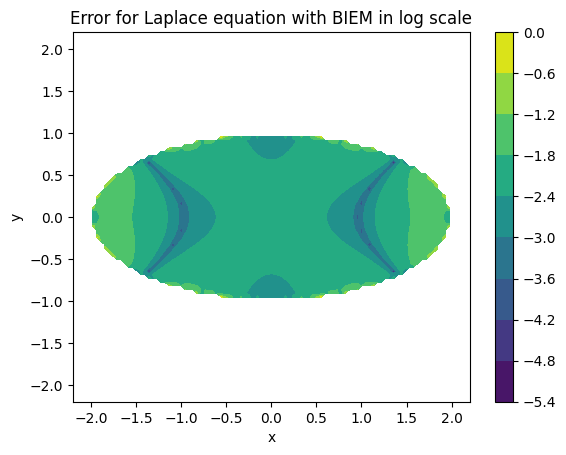

In [4]:
U = (X**2 - Y**2) / (2*np.pi)
E = u - U + np.finfo(float).eps
plt.contourf(X, Y, np.log10(np.abs(E)))
plt.colorbar()
plt.title("Error for Laplace equation with BIEM in log scale")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

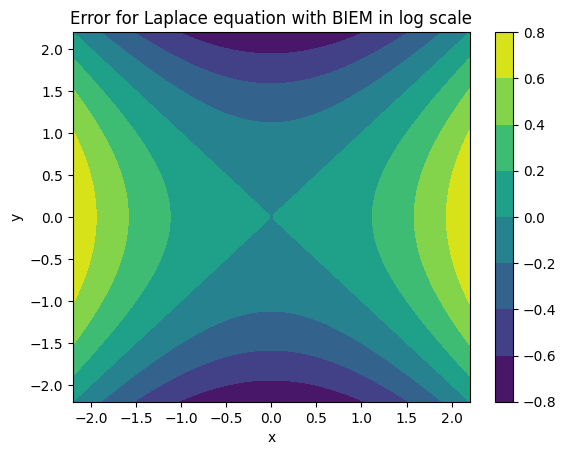

In [5]:
U = (X**2 - Y**2) / (2*np.pi)
plt.contourf(X, Y, U)
plt.colorbar()
plt.title("Error for Laplace equation with BIEM in log scale")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

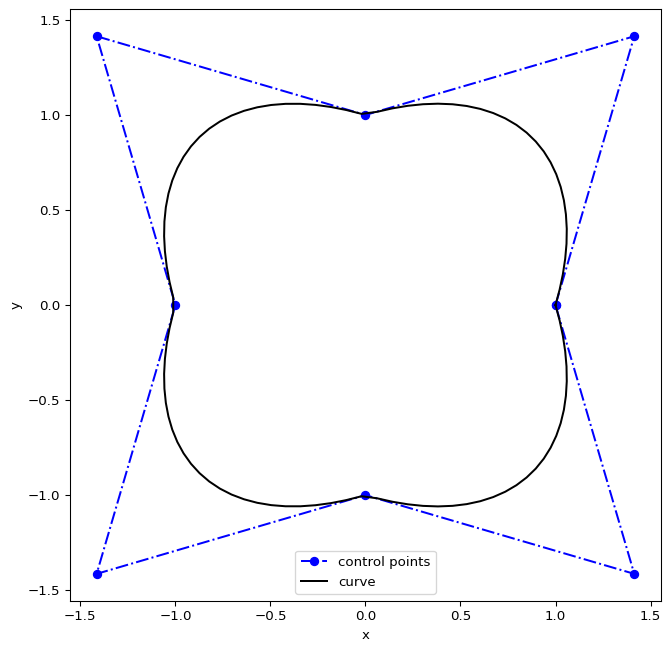

In [35]:
from geomdl.visualization import VisMPL

# Function to create a NURBS curve for a circle of radius 1 centered at the origin
def create_circle_curve():
    # Initialize a NURBS curve object
    curve = NURBS.Curve()

    # Set the degrees of the curve
    curve.degree = 2

    # Set the control points and weights for a circle of radius 1 centered at the origin
    curve.ctrlptsw = [
        [1.0, 0.0, 0.0, 1.0],
        [1.0, 1.0, 0.0, 0.7071067811865476],
        [0.0, 1.0, 0.0, 1.0],
        [-1.0, 1.0, 0.0, 0.7071067811865476],
        [-1.0, 0.0, 0.0, 1.0],
        [-1.0, -1.0, 0.0, 0.7071067811865476],
        [0.0, -1.0, 0.0, 1.0],
        [1.0, -1.0, 0.0, 0.7071067811865476],
        [1.0, 0.0, 0.0, 1.0]
    ]

    # Set the knot vector
    curve.knotvector = [0, 0, 0, 1/4, 1/4, 1/2, 1/2, 3/4, 3/4, 1, 1, 1]

    return curve

# Create the curve
curve = create_circle_curve()

# Visualize the curve using the VisMPL module
vis_comp = VisMPL.VisCurve2D()
curve.vis = vis_comp
curve.render() 

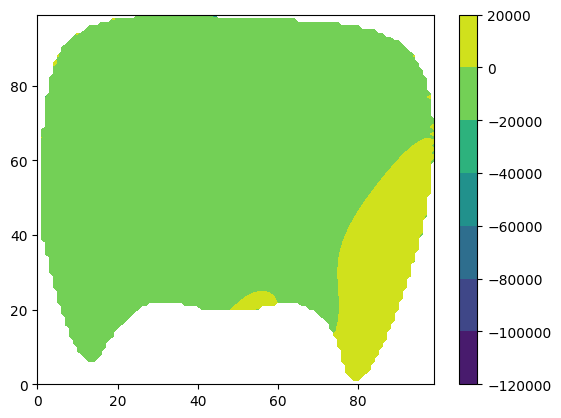

In [6]:
N = 200

s_values = np.linspace(0, 1, N+1)
s_values = s_values[:-1]
crvpts = np.array([Z(t, curve) for t in s_values])

xmin = int(min(crvpts[:,0]))
xmax = int(max(crvpts[:,0]))
ymin = int(min(crvpts[:,1]))
ymax = int(max(crvpts[:,1]))
nxgrid = 100
nygrid = 100

x = [Z(s, curve)[0] for s in s_values]
y = [Z(s, curve)[1] for s in s_values]

tx = [Z_derivative(s, curve)[0] for s in s_values]
ty = [Z_derivative(s, curve)[1] for s in s_values]

ax = [Z_2nd_derivative(s, curve)[0] for s in s_values]
ay = [Z_2nd_derivative(s, curve)[1] for s in s_values]

nx = np.zeros(N)
ny = np.zeros(N)
w = np.zeros(N)

for i in range(N):
    nx[i] = ax[i] / np.sqrt(ax[i] ** 2 + ay[i] ** 2)
    ny[i] = ay[i] / np.sqrt(ax[i] ** 2 + ay[i] ** 2)
    h = 1 / (N)
    w[i] = h * np.sqrt(tx[i] ** 2 + ty[i] ** 2)

f = np.zeros(N)
for i in range(N):
    f[i] = (x[i]**2 - y[i]**2) / (2*np.pi)

K = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if i == j:
            kappa = (tx[j] * ax[j] - ty[j] * ay[j]) / (tx[j] ** 2 + ty[j] ** 2) ** 1.5
            kappa = 1
            K[i, j] = -kappa / (4 * np.pi) * w[j]
        else:
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dot = nx[j] * dx + ny[j] * dy
            r = np.sqrt(dx ** 2 + dy ** 2)
            K[i, j] = dot / (2 * np.pi * r ** 2)
            K[i, j] = K[i, j] * w[j]

sigma = np.linalg.solve(-np.eye(N) / 2 + K, f)

xlin = np.linspace(xmin, xmax, nxgrid)
ylin = np.linspace(ymin, ymax, nygrid)
X, Y = np.meshgrid(xlin, ylin)

u = np.zeros((nxgrid, nygrid))
for i in range(nxgrid):
    for j in range(nygrid):
        if not point_inside_curve([X[i,j], Y[i,j]], crvpts):
            u[i, j] = np.nan
        else:
            u[i, j] = 0
        for k in range(N):
            dx = X[i, j] - x[k]
            dy = Y[i, j] - y[k]
            dot = nx[k] * dx + ny[k] * dy
            r = np.sqrt(dx ** 2 + dy ** 2)
            u[i, j] = u[i, j] - dot / (2 * np.pi * r ** 2) * w[k] * sigma[k]     

plt.contourf(u)
plt.colorbar()
plt.show()

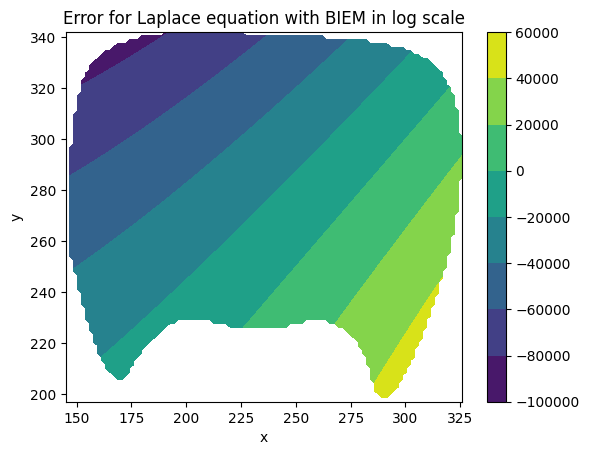

In [13]:
U = (X**2 - Y**2) 
E = U - u + u + np.finfo(float).eps
plt.contourf(X, Y, E)
plt.colorbar()
plt.title("Error for Laplace equation with BIEM in log scale")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

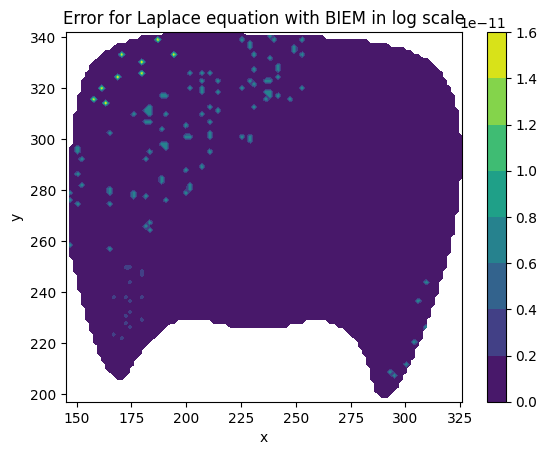

In [15]:
U = (X**2 - Y**2) 
Z = U - E + np.finfo(float).eps
plt.contourf(X, Y, np.abs(Z))
plt.colorbar()
plt.title("Error for Laplace equation with BIEM in log scale")
plt.xlabel("x")
plt.ylabel("y")
plt.show()